## A pipeline for processing and analyzing multiplexed images

#### Related project: A spatial single-cell type map of adult human spermatogenesis (Cecilia Bergström group)

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skimage import io, filters, measure, segmentation, color

import warnings
warnings.filterwarnings('ignore')


### Define input path and image of interest

In [2]:
# define input path
inputpath = '' # example '/Users/projects/'

# read reference image and select DAPI channel
ref_img = io.imread(os.path.join(inputpath, ''))
nuclei = ref_img[0,:,:]


### Run StarDist on the DAPI channel and save both label and binary masks

In [3]:
from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# get predictions for nuclei 
labels, _ = model.predict_instances(normalize(nuclei))

# get binary mask
binary_mask = labels.copy()
binary_mask[binary_mask > 0] = 1

io.imsave(inputpath + 'labels.tif',labels)
io.imsave(inputpath + 'binary.tif',binary_mask)


2023-05-17 11:12:50.806159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
1/1 [==============================] - 1s 747ms/step


### Alternatively, run StarDist on the BioEngine (https://bioimage.io/#/)

In [ ]:
try:
    # For pyodide in the browser
    import micropip
    await micropip.install(['pyotritonclient', 'kaibu-utils'])
except ImportError:
    # For native python with pip
    import subprocess
    subprocess.call(['pip', 'install', 'pyotritonclient', 'kaibu-utils'])

import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pyotritonclient import execute
from kaibu_utils import fetch_image

In [ ]:
# obtain the model config
image = nuclei.astype('uint16')
param = {'diameter': 30}

# run inference
results = await execute([image, param],
                              server_url='https://ai.imjoy.io/triton',
                              model_name='stardist',
                              decode_bytes=True)
mask = results['mask']

### Display segmentation output for the DAPI image

Text(0.5, 1.0, 'prediction + input overlay')

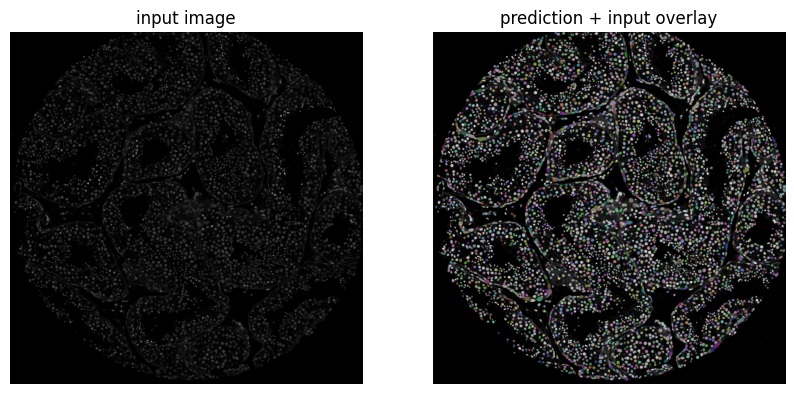

In [5]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(nuclei, cmap="gray", vmin=0, vmax=np.amax(nuclei))
ax1.axis("off")
ax1.set_title('input image')

ax2.imshow(render_label(labels, img=nuclei))
ax2.axis("off")
ax2.set_title('prediction + input overlay')


### Expand labels to incorporate cells' neighborhoods

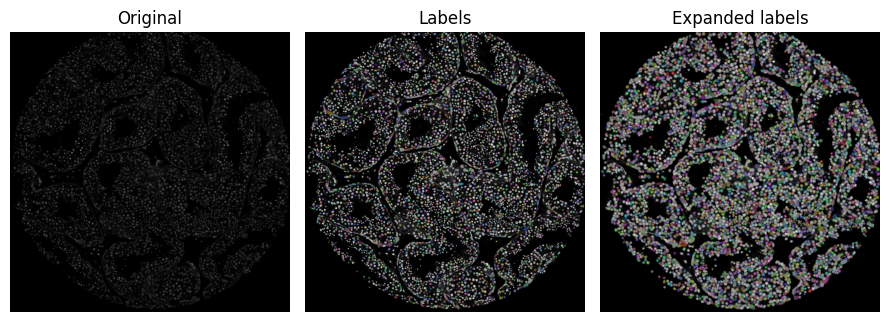

In [6]:
enlarged_labels = segmentation.expand_labels(labels, distance=3)

io.imsave(inputpath + 'labels_enlarged.tif',enlarged_labels)
io.imsave(inputpath + 'labels.tif',labels)

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(nuclei, cmap="gray", vmin=0, vmax=np.amax(nuclei))
axes[0].set_title("Original")

axes[1].imshow(render_label(labels, img=nuclei))
axes[1].set_title("Labels")

axes[2].imshow(render_label(enlarged_labels, img=nuclei))
axes[2].set_title("Expanded labels")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()

### Retrieve quantitative measures
#### Get mean fluorescence intensity for each nuclei and for each channel and save results on a dataframe


In [7]:
images = [ref_img[(x),:,:] for x in range(ref_img.shape[0])]

properties = ['label', 'intensity_mean']

tables = [measure.regionprops_table(labels, image, properties=properties)
          for image in images]
tables = [pd.DataFrame(table) for table in tables] # create dataframe for each table
tables = [table.set_index('label') for table in tables] # reset segmentaiton label as table index

mean_intens = pd.concat(tables, axis=1)
mean_intens.columns = ['DAPI','OPAL480','OPAL520','OPAL570','OPAL620','OPAL690','OPAL780','Autofluorescence']
mean_intens


,DAPI,OPAL480,OPAL520,OPAL570,OPAL620,OPAL690,OPAL780,Autofluorescence
label,,,,,,,,
1,26.035524,14.300614,4.995111,0.350100,1.136611,5.724508,0.156195,7.793913
2,21.532436,8.359867,12.215379,0.196066,2.934078,0.515699,0.268638,8.096065
3,19.351835,6.115076,7.944694,0.423977,2.742765,1.259455,3.121698,7.400581
4,24.532646,8.237246,5.902200,0.393453,1.481363,6.433295,0.288688,7.997678
5,28.376553,15.220303,7.021153,0.328195,1.617007,5.684114,0.119549,8.465516
...,...,...,...,...,...,...,...,...
4871,8.135657,3.105014,6.383780,0.187832,0.667581,0.115370,0.076790,7.351696
4872,30.657665,2.373475,3.327082,0.213146,0.420516,0.139443,0.075289,7.391753
4873,15.697083,2.994924,6.047880,0.455162,16.691502,3.263204,0.413688,7.335554


### Visualizing the average intensity distribution for each channel

In [8]:
# -------------------------------- #
# Plotting histograms              #
# -------------------------------- #

def getHistData(histData,n_bins,xlim,ylim,x,y,title):
    counts, bins = np.histogram(histData,bins=n_bins,density=False)
    binWidth = bins[1] - bins[0]
    axarr[x,y].bar(bins[1:], counts, width=binWidth, facecolor='b', alpha=0.5)
    #axarr[x,y].set_xlim([0,xlim])
    axarr[x,y].set_ylim([0,ylim])
    axarr[x,y].set_title(title)
    

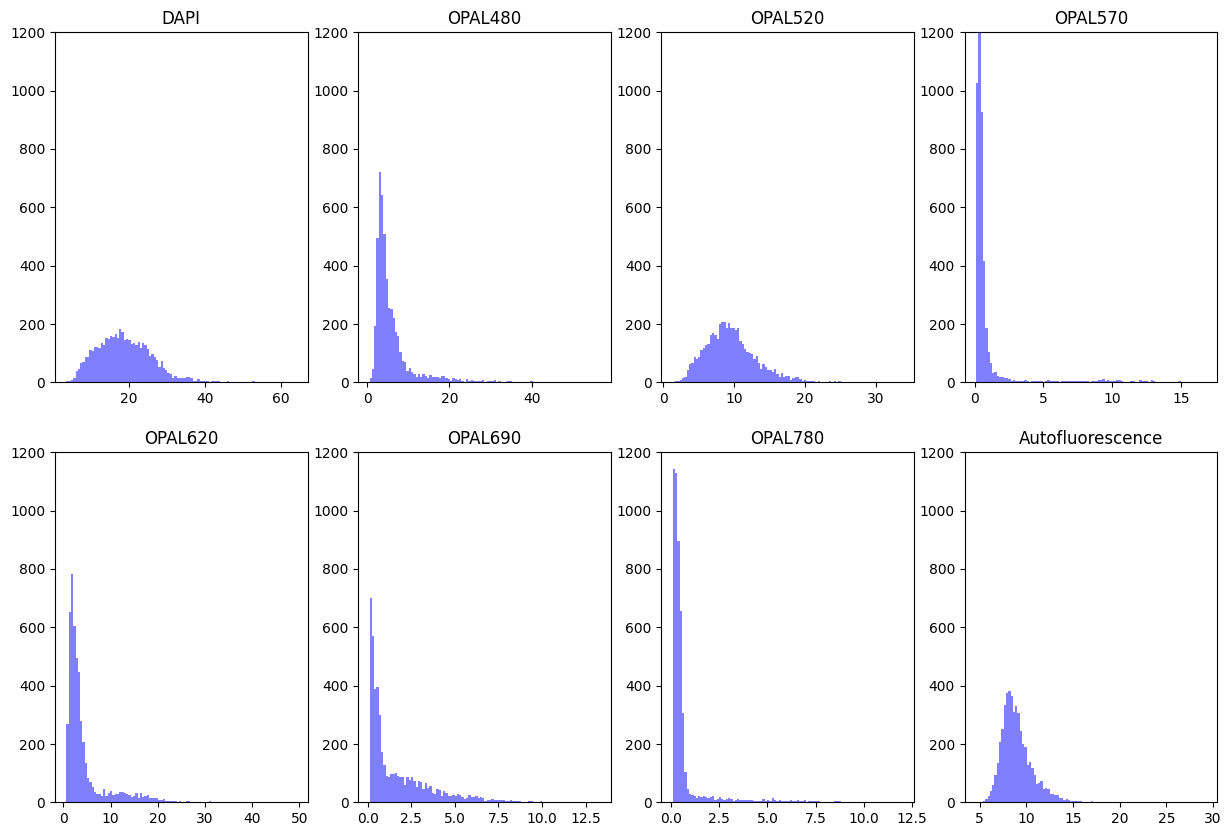

In [9]:
# create subplot
fig, axarr = plt.subplots(2,4, figsize=(15, 10)) 
nBins = 100
xlim = 80
ylim = 1200

getHistData(mean_intens['DAPI'],nBins,xlim,ylim,0,0,'DAPI')
getHistData(mean_intens['OPAL480'],nBins,xlim,ylim,0,1,'OPAL480')
getHistData(mean_intens['OPAL520'],nBins,xlim,ylim,0,2,'OPAL520')
getHistData(mean_intens['OPAL570'],nBins,xlim,ylim,0,3,'OPAL570')
getHistData(mean_intens['OPAL620'],nBins,xlim,ylim,1,0,'OPAL620')
getHistData(mean_intens['OPAL690'],nBins,xlim,ylim,1,1,'OPAL690')
getHistData(mean_intens['OPAL780'],nBins,xlim,ylim,1,2,'OPAL780')
getHistData(mean_intens['Autofluorescence'],nBins,xlim,ylim,1,3,'Autofluorescence')


### Defining threshold for each column

In [10]:
from skimage.filters import threshold_otsu

hist, bin_edges = np.histogram(mean_intens['OPAL620'], 1000, density=True)

thresh = threshold_otsu(mean_intens['OPAL620'])
thresh


8.646499302471057

In [11]:
thresh = [threshold_otsu(mean_intens[col]) for col in mean_intens.columns] # calculate threshold for all cols
thresh


[19.723417929839343,
 12.636522020329721,
 10.474706615554169,
 4.8793320248878445,
 8.646499302471057,
 2.751657826396695,
 2.9887613701357623,
 9.639450075104833]

### Filtering mean intensity values by threshold

In [12]:
filtered_mean_intens = mean_intens

for col, th in zip(mean_intens.columns,thresh):
    filtered_mean_intens.loc[filtered_mean_intens[col] < th, col] = -1
    
filtered_mean_intens


,DAPI,OPAL480,OPAL520,OPAL570,OPAL620,OPAL690,OPAL780,Autofluorescence
label,,,,,,,,
1,26.035524,14.300614,-1.000000,-1.0,-1.000000,5.724508,-1.000000,-1.0
2,21.532436,-1.000000,12.215379,-1.0,-1.000000,-1.000000,-1.000000,-1.0
3,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,3.121698,-1.0
4,24.532646,-1.000000,-1.000000,-1.0,-1.000000,6.433295,-1.000000,-1.0
5,28.376553,15.220303,-1.000000,-1.0,-1.000000,5.684114,-1.000000,-1.0
...,...,...,...,...,...,...,...,...
4871,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0
4872,30.657665,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.0
4873,-1.000000,-1.000000,-1.000000,-1.0,16.691502,3.263204,-1.000000,-1.0
